In [99]:
import math
import random

In [100]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [65]:
# a = Value(2, label='a')
# b = Value(-3, label='b')
# c = Value(10, label='c')
# e = a * b; e.label='e'
# d = e + c; d.label='d'
# d, d._prev, d._op

(Value(data=4), {Value(data=-6), Value(data=10)}, '+')

In [3]:
a = Value(2.0)
a*3, a+5, 4*a

(Value(data=6.0), Value(data=7.0), Value(data=8.0))

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

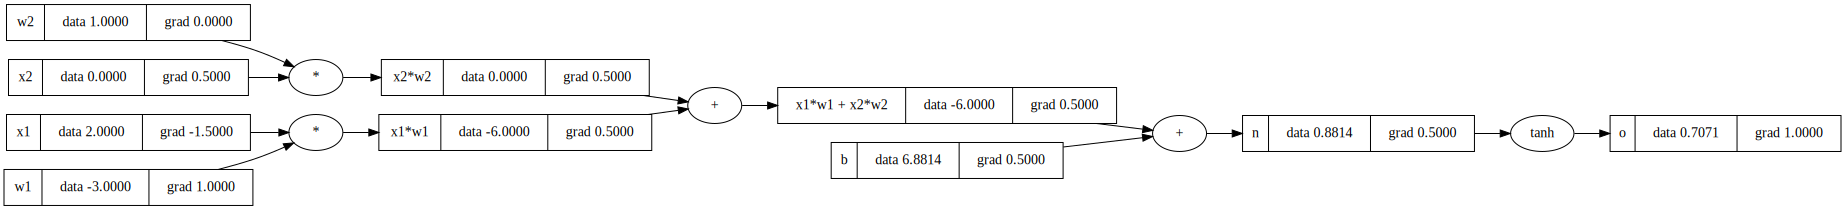

In [6]:
o.backward()
draw_dot(o)

In [71]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def parameters(self):
        return self.w + [self]

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

In [16]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.23166861861212334)

In [73]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

In [30]:
x = [2.0, 3.0]

l = Layer(2, 3)
l(x)

[Value(data=0.47954880683801665),
 Value(data=-0.9870099995697345),
 Value(data=-0.7457232195459765)]

In [76]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [93]:
n = MLP(3, [4,4,1])
len(n.parameters())

41

In [94]:
x = [2.0, 3.0, -1.0]
n(x)

Value(data=0.18669536716710736)

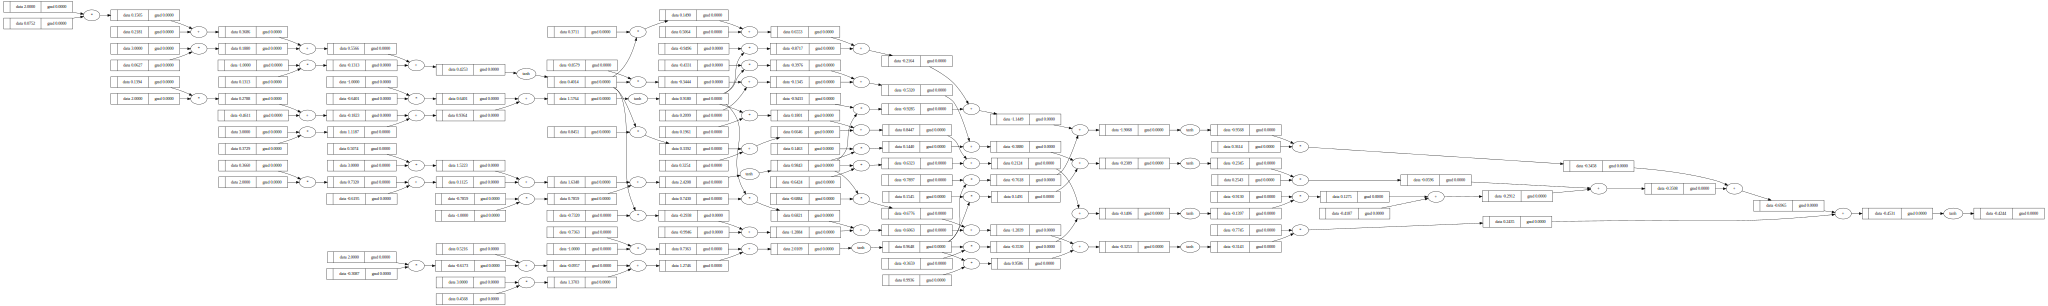

In [80]:
draw_dot(n(x))

In [95]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [97]:
for k in range(20):

    #forward
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward
    for p in n.parameters():
        p.grad = 0
        
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.07 * p.grad
    
    print(k, loss.data)


0 2.2545452678799856e-14
1 2.2545452678799856e-14
2 2.2545452678799856e-14
3 2.2545452678799856e-14
4 2.2545452678799856e-14
5 2.2545452678799856e-14
6 2.2545452678799856e-14
7 2.2545452678799856e-14
8 2.2545452678799856e-14
9 2.2545452678799856e-14
10 2.2545452678799856e-14
11 2.2545452678799856e-14
12 2.2545452678799856e-14
13 2.2545452678799856e-14
14 2.2545452678799856e-14
15 2.2545452678799856e-14
16 2.2545452678799856e-14
17 2.2545452678799856e-14
18 2.2545452678799856e-14
19 2.2545452678799856e-14


In [98]:
ypred

[Value(data=0.9999999917767463),
 Value(data=-0.9999999999967675),
 Value(data=-0.9999998888925066),
 Value(data=0.9999998993374167)]